In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install numpy==1.23.5
import matplotlib.pyplot as plt
import os
import sys

args = 0
os.environ['CUDA_VISIBLE_DEVICES'] = f''
# print(f'Selected GPU {args}')

import jax
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx
import jaxkern as jk

from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# import uicsmodels

print('Jax version:        ', jax.__version__)
print('Python version:     ', sys.version)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

2024-06-19 21:19:18.152964: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Jax version:         0.4.16
Python version:      3.10.12 (main, Jul  5 2023, 18:54:27) [GCC 11.2.0]
Jax default backend: cpu
Jax devices:         [CpuDevice(id=0)]


In [3]:
sys.path.append('/home/davcic/CP_Testing')
sys.path.append('/home/davcic/CP_Testing/Classes')

from GP_CP import GP_CP_Marginal, GP_CP_Latent

from New_kernel_1 import Discontinuous_multiple
from New_kernel_1 import Discontinuous_multiple_params
from New_kernel_1 import Discontinuous_multiple_params_hyper
from New_kernel_1 import Discontinuous_multiple_params_hyper_periodic
from Poisson_Process_added import Poisson_Process_hyper
from fullgp import FullMarginalGPModelhyper_mult
from Uniform_modified import Uniform_mod
from Normal_modified import LogNormal_mod

## Dataset RBF 3 CPs

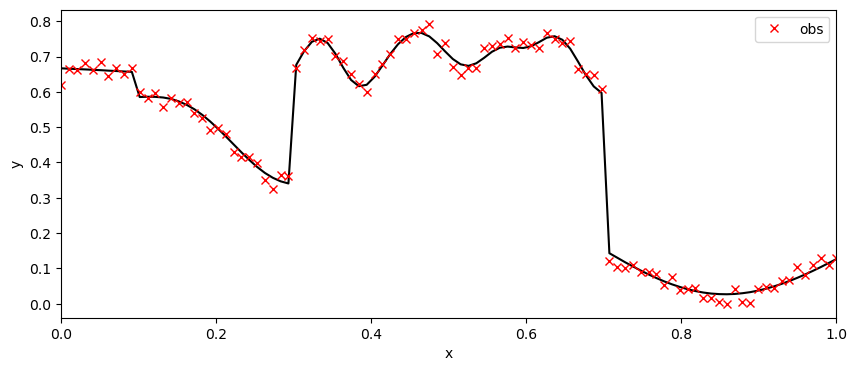

In [4]:
name = 'Toy_dataset_RBF_3/'

key = jrnd.PRNGKey(12345)

lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.3, 0.1, 0.7])
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params_hyper(base_kernel)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    kernel = dict(lengthscale=lengthscale_,
                                    variance=output_scale_,
                                    num = x0),
                    obs_noise=obs_noise_)


max_y = jnp.max(jnp.abs(y)) 
min_y = jnp.min(y)
# sign_min_y = jnp.sign(jnp.min(y)) * min_y
f_new = (f_true - min_y)/(max_y - min_y)
y_new = (y - min_y)/(max_y - min_y)


plt.figure(figsize=(10, 4))
plt.plot(x, f_new, 'k', label=r'')
plt.plot(x, y_new, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend()
plt.show()

max_CP = 10
T = 1

priors = dict(kernel= dict(lengthscale=LogNormal_mod(0, 2, max_CP+1),
                             variance=LogNormal_mod(0, 2, max_CP+1),
                             num=Poisson_Process_hyper(max_CP, T)),
              likelihood=dict(obs_noise=LogNormal_mod(0, 1, 1)),
              hyper = dict(hyper_1 = LogNormal_mod(0, 1, 1)) 
                       )

num_particles = 1000

jnp.save(name + 'data.npy', y_new)
jnp.save(name + 'orig_data.npy', y)
jnp.save(name + 'ground_truth.npy', ground_truth)



GP_marginal = GP_CP_Marginal(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, ground_truth=ground_truth)
jnp.save(name + 'GP_marginal_untrained_orig.npy', GP_marginal)

GP_latent = GP_CP_Latent(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, ground_truth=ground_truth)
jnp.save(name + 'GP_latent_untrained_orig.npy', GP_latent)

# print(min_y)

## Dataset RBF 6 CPs

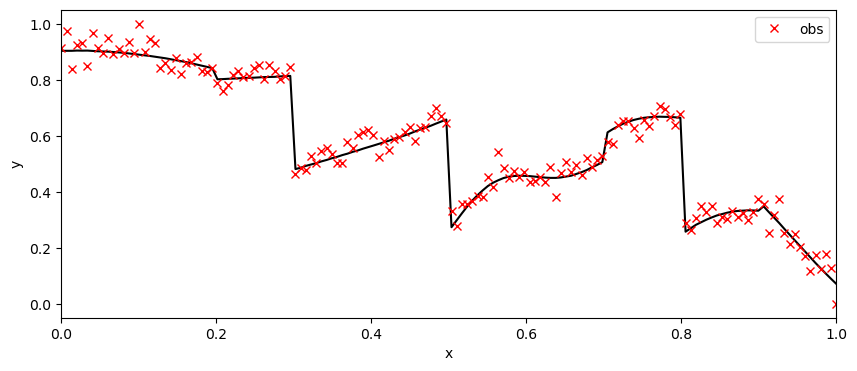

In [5]:
name = 'Toy_dataset_RBF_6/'

key = jrnd.PRNGKey(1234)

lengthscale_ = jrnd.lognormal(key, shape = (7, )) / 4
output_scale_ = jrnd.uniform(key, (7, )) * 3
obs_noise_ = 0.1
n = 150
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.sort(jnp.array([0.3, 0.5, 0.2, 0.7, 0.9, 0.8]))
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params_hyper(base_kernel)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

max_y = jnp.max(jnp.abs(y)) 
min_y = jnp.min(y)
# sign_min_y = jnp.sign(jnp.min(y)) * min_y
f_new = (f_true - min_y)/(max_y - min_y)
y_new = (y - min_y)/(max_y - min_y)

ground_truth = dict(f=f_true,
                    kernel = dict(lengthscale=lengthscale_,
                                    variance=output_scale_,
                                    num = x0),
                    obs_noise=obs_noise_)

plt.figure(figsize=(10, 4))
plt.plot(x, f_new, 'k', label=r'')
plt.plot(x, y_new, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend()
plt.show()

max_CP = 10
T = 1

priors = dict(kernel= dict(lengthscale=LogNormal_mod(0, 2, max_CP+1),
                             variance=LogNormal_mod(0, 2, max_CP+1),
                             num=Poisson_Process_hyper(max_CP, T)),
              likelihood=dict(obs_noise=LogNormal_mod(0, 1, 1)),
              hyper = dict(hyper_1 = LogNormal_mod(0, 1, 1)) 
                       )

num_particles = 1000

jnp.save(name + 'data.npy', y_new)
jnp.save(name + 'orig_data.npy', y)
jnp.save(name + 'ground_truth.npy', ground_truth)

GP_marginal = GP_CP_Marginal(x, y_new, cov_fn=kernel, priors=priors, num_particles=num_particles, ground_truth=ground_truth)
jnp.save(name + 'GP_Marginal/GP_marginal_untrained.npy', GP_marginal)

GP_latent = GP_CP_Latent(x, y_new, cov_fn=kernel, priors=priors, num_particles=num_particles, ground_truth=ground_truth)
jnp.save(name + 'GP_Latent/GP_latent_untrained.npy', GP_latent)

## Dataset Periodic 3 CPs

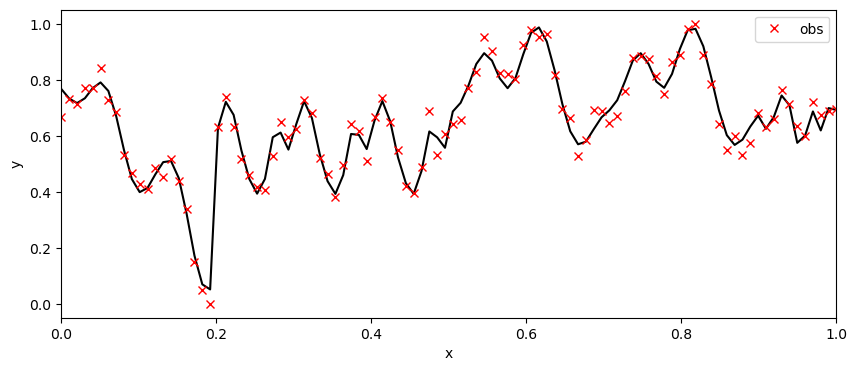

In [6]:
name = 'Toy_dataset_Periodic/'

key = jrnd.PRNGKey(12345)

lengthscale_ = jnp.array([0.2, 0.8, 0.5, 0.1])
output_scale_ = jnp.array([2, 4, 1, 0.5])
period_ = jnp.array([0.5, 0.1, 0.2, 0.07])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.5, 0.2, 0.9])
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.Periodic()
kernel = Discontinuous_multiple_params_hyper_periodic(base_kernel)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        period = period_, 
                                        num=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))

ground_truth = dict(f=f_true,
                    kernel = dict(lengthscale=lengthscale_,
                                    variance=output_scale_,
                                    num = x0),
                    obs_noise=obs_noise_)

max_y = jnp.max(jnp.abs(y)) 
min_y = jnp.min(y)
# sign_min_y = jnp.sign(jnp.min(y)) * min_y
f_new = (f_true - min_y)/(max_y - min_y)
y_new = (y - min_y)/(max_y - min_y)


plt.figure(figsize=(10, 4))
plt.plot(x, f_new, 'k', label=r'')
plt.plot(x, y_new, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend()
plt.show()

max_CP = 10
T = 1

priors = dict(kernel= dict(lengthscale=LogNormal_mod(0, 2, max_CP+1),
                             variance=LogNormal_mod(0, 2, max_CP+1), 
                             period=LogNormal_mod(0, 2, max_CP+1),
                             num=Poisson_Process_hyper(max_CP, T)),
              likelihood=dict(obs_noise=LogNormal_mod(0, 1, 1)),
              hyper = dict(hyper_1 = LogNormal_mod(0, 1, 1)) 
                       )

num_particles = 1000

jnp.save(name + 'data.npy', y_new)
jnp.save(name + 'orig_data.npy', y)
jnp.save(name + 'ground_truth.npy', ground_truth)

# GP_marginal = GP_CP_Marginal(x, y_new, cov_fn=kernel, priors=priors, num_particles=num_particles, ground_truth=ground_truth)
# jnp.save(name + 'GP_marginal_untrained.npy', GP_marginal)

# GP_latent = GP_CP_Latent(x, y_new, cov_fn=kernel, priors=priors, num_particles=num_particles, ground_truth=ground_truth)
# jnp.save(name + 'GP_latent_untrained.npy', GP_latent)
GP_marginal = GP_CP_Marginal(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, ground_truth=ground_truth)
jnp.save(name + 'GP_marginal_untrained_orig.npy', GP_marginal)

GP_latent = GP_CP_Latent(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, ground_truth=ground_truth)
jnp.save(name + 'GP_latent_untrained_orig.npy', GP_latent)

## Dataset Periodic + RBF

In [11]:
name = 'Toy_dataset_RBF_Periodic/'

GP_Marginal = jnp.load(name + '/GP_Marginal/GP_marginal_untrained.npy', allow_pickle = True)[()]
GP_Marginal.X

Array([[0.        ],
       [0.01010101],
       [0.02020202],
       [0.03030303],
       [0.04040404],
       [0.05050505],
       [0.06060606],
       [0.07070707],
       [0.08080808],
       [0.09090909],
       [0.1010101 ],
       [0.11111111],
       [0.12121212],
       [0.13131313],
       [0.14141414],
       [0.15151515],
       [0.16161616],
       [0.17171717],
       [0.18181818],
       [0.19191919],
       [0.2020202 ],
       [0.21212121],
       [0.22222222],
       [0.23232323],
       [0.24242424],
       [0.25252525],
       [0.26262626],
       [0.27272727],
       [0.28282828],
       [0.29292929],
       [0.3030303 ],
       [0.31313131],
       [0.32323232],
       [0.33333333],
       [0.34343434],
       [0.35353535],
       [0.36363636],
       [0.37373737],
       [0.38383838],
       [0.39393939],
       [0.4040404 ],
       [0.41414141],
       [0.42424242],
       [0.43434343],
       [0.44444444],
       [0.45454545],
       [0.46464646],
       [0.474

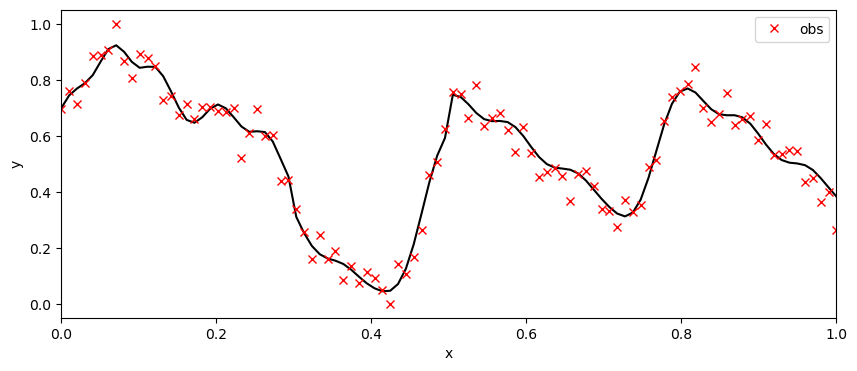

In [7]:
name = 'Toy_dataset_RBF_Periodic/'

key = jrnd.PRNGKey(123456)

base_kernel1 = jk.RBF()
base_kernel2 = jk.Periodic()

# kernel = Discontinuous_multiple_params_hyper(base_kernel)
kernel = Discontinuous_multiple_params_hyper(base_kernel1) + Discontinuous_multiple_params_hyper_periodic(base_kernel2)

key, key1 = jrnd.split(key)
lengthscale1 = jnp.array([0.1, 1])
variance1 = jnp.array([2, 1])
lengthscale2 = jnp.array([0.4, 0.5])
variance2 = jnp.array([0.5, 2])
period = jnp.array([0.2, 0.3])
num1 = jnp.array([0.5])
num2 = jnp.array([0.3])

params = [dict(lengthscale= lengthscale1,
                            variance = variance1,
                            num = num1), 
              dict(lengthscale= lengthscale2,
                            variance = variance2,
                            period = period, 
                            num = num2)]
x = jnp.linspace(0, 1, 100)


K = kernel.cross_covariance(params, x, x)
# plt.imshow(K)
# plt.show()

n = 100
obs_noise_ = 0.3
L = jnp.linalg.cholesky(K+ 1e-6*jnp.eye(n))
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n,))


ground_truth = dict(f=f_true,
                    kernel = [dict(lengthscale=lengthscale1,
                                    variance=variance1,
                                    num = num1),
                             dict(lengthscale=lengthscale2,
                                    variance=variance2,
                                    period = period,
                                    num = num2)],
                    obs_noise=obs_noise_,
                    )

max_y = jnp.max(jnp.abs(y)) 
min_y = jnp.min(y)
# sign_min_y = jnp.sign(jnp.min(y)) * min_y
f_new = (f_true - min_y)/(max_y - min_y)
y_new = (y - min_y)/(max_y - min_y)


plt.figure(figsize=(10, 4))
plt.plot(x, f_new, 'k', label=r'')
plt.plot(x, y_new, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend()
plt.show()


max_CP = 10
T = 1

priors = dict(kernel=  [dict(lengthscale=LogNormal_mod(0, 2, max_CP+1),
                             variance=LogNormal_mod(0, 2, max_CP+1),
                             num=Poisson_Process_hyper(max_CP, T)),
                        dict(lengthscale=LogNormal_mod(0, 2, max_CP+1),
                             variance=LogNormal_mod(0, 2, max_CP+1), 
                             period=LogNormal_mod(0, 2, max_CP+1),
                             num=Poisson_Process_hyper(max_CP, T))],
              likelihood=dict(obs_noise=LogNormal_mod(0, 1, 1)),
              hyper = [dict(hyper_1 = LogNormal_mod(0, 1, 1)), 
                       dict(hyper_2 = LogNormal_mod(0, 1, 1))])

num_particles = 1000

jnp.save(name + 'data.npy', y_new)
jnp.save(name + 'orig_data.npy', y)
jnp.save(name + 'ground_truth.npy', ground_truth)

GP_marginal = GP_CP_Marginal(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, ground_truth=ground_truth)
jnp.save(name + 'GP_marginal_untrained_orig.npy', GP_marginal)

GP_latent = GP_CP_Latent(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, ground_truth=ground_truth)
jnp.save(name + 'GP_latent_untrained_orig.npy', GP_latent)

## Dataset Cauchy distributed data

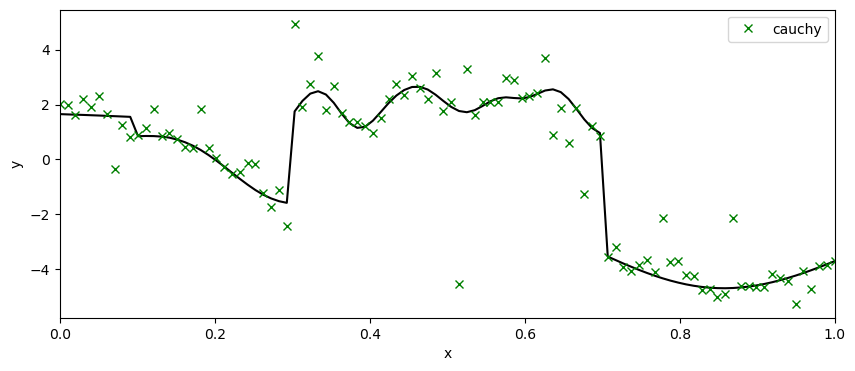

In [7]:
name = 'Toy_dataset_Cauchy/'

key = jrnd.PRNGKey(12345)

lengthscale_ = jnp.array([0.5, 0.1, 0.04, 0.2])
output_scale_ = jnp.array([3, 2, 1, 5])
obs_noise_ = 0.2
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]
x0 = jnp.array([0.3, 0.1, 0.7])
# x0 = jnp.concatenate((jnp.array([0]), x0, jnp.array([x.shape[0]])))
#x0 = jnp.append(jnp.zeros(1), x0, jnp.array(x.shape[0]))
base_kernel = jk.RBF()
kernel = Discontinuous_multiple_params_hyper(base_kernel)
K = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_,
                                        num=x0),
                            x=x, y=x)+ 1e-6*jnp.eye(n)

L = jnp.linalg.cholesky(K)
z = jrnd.normal(key, shape=(n,))

f_true = jnp.dot(L, z) + jnp.ones_like(z)
key, obs_key = jrnd.split(key)
# y = f_true + obs_noise_*jrnd.normal(obs_key, shape=(n, ))


# import numpy as np
# from scipy.stats import laplace
# import matplotlib.pyplot as plt
# rv = laplace(loc = 0, scale = 0.2)
# y2 = f_true + rv.rvs(size=n)

key, new_key = jrnd.split(obs_key)
uni_noise = jrnd.uniform(new_key, shape = (n, ))
cauchy_noise = 0 + obs_noise_ * jnp.tan(jnp.pi * (uni_noise - 1/2))
y = f_true + cauchy_noise

ground_truth = dict(f=f_true,
                    kernel = dict(lengthscale=lengthscale_,
                                    variance=output_scale_,
                                    num = x0),
                    obs_noise=obs_noise_)
max_y = jnp.max(jnp.abs(y)) 
min_y = jnp.min(y)
# sign_min_y = jnp.sign(jnp.min(y)) * min_y
f_new = (f_true - min_y)/(max_y - min_y)
y_new = (y - min_y)/(max_y - min_y)


plt.figure(figsize=(10, 4))
# plt.plot(x, f_new, 'k', label=r'')
# plt.plot(x, y_new, 'rx', label='obs')
plt.plot(x, f_true, 'k', label=r'')
# plt.plot(x, y, 'rx', label='normal')
# plt.plot(x, y2, 'bx', label='laplace')
plt.plot(x, y, 'gx', label='cauchy')

plt.xlabel('x')
plt.ylabel('y')
plt.xlim([0., 1.])
plt.legend()
plt.show()


max_CP = 10
T = 1

priors = dict(kernel= dict(lengthscale=LogNormal_mod(0, 2, max_CP+1),
                             variance=LogNormal_mod(0, 2, max_CP+1),
                             num=Poisson_Process_hyper(max_CP, T)),
              likelihood=dict(obs_noise=LogNormal_mod(0, 1, 1)),
              hyper = dict(hyper_1 = LogNormal_mod(0, 1, 1)) 
                       )

num_particles = 1000

jnp.save(name + 'data.npy', y_new)
jnp.save(name + 'orig_data.npy', y)
jnp.save(name + 'ground_truth.npy', ground_truth)

GP_marginal = GP_CP_Marginal(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, ground_truth=ground_truth)
jnp.save(name + 'GP_Marginal/GP_marginal_untrained_orig.npy', GP_marginal)

from Cauchy_likelihood import Cauchy
GP_latent = GP_CP_Latent(x, y, cov_fn=kernel, priors=priors, num_particles=num_particles, ground_truth=ground_truth, likelihood = Cauchy())
jnp.save(name + 'GP_Latent/GP_latent_untrained_orig.npy', GP_latent)

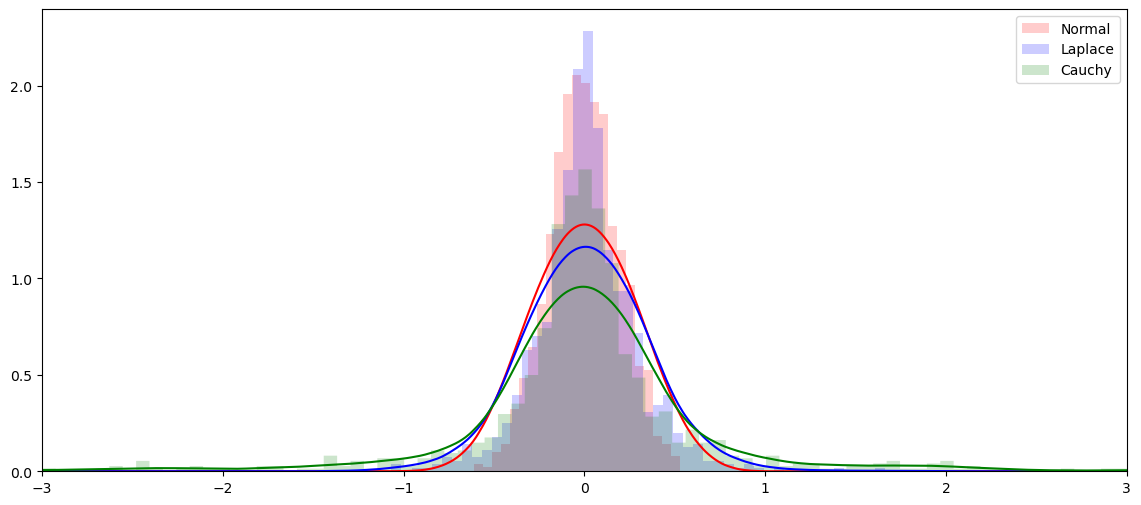

In [9]:
from sklearn.neighbors import KernelDensity

fig = plt.figure(figsize =(14, 6))

X_plot = jnp.linspace(-3, 3, 1000)[:, np.newaxis]

Normal_noise = obs_noise_*jrnd.normal(obs_key, shape = (1000,))

kde_kernel = "epanechnikov"
kde = KernelDensity(kernel=kde_kernel, bandwidth=0.5).fit(Normal_noise[:, jnp.newaxis])
log_dens = kde.score_samples(X_plot)
plt.plot(
    X_plot[:, 0],
    jnp.exp(log_dens),
    color='red',
    linestyle="-",
    # label="kernel = '{0}'".format(kde_kernel),
)

Laplace_noise = rv.rvs(size=1000)

kde_kernel = "epanechnikov"
kde = KernelDensity(kernel=kde_kernel, bandwidth=0.5).fit(Laplace_noise[:, jnp.newaxis])
log_dens = kde.score_samples(X_plot)
plt.plot(
    X_plot[:, 0],
    jnp.exp(log_dens),
    color='blue',
    linestyle="-",
    # label="kernel = '{0}'".format(kde_kernel),
)


uni_noise = jrnd.uniform(obs_key, shape = (1000, ))
cauchy_noise = 0 + obs_noise_ * jnp.tan(jnp.pi * (uni_noise - 1/2))

kde_kernel = "epanechnikov"
kde = KernelDensity(kernel=kde_kernel, bandwidth=0.5).fit(cauchy_noise[:, jnp.newaxis])
log_dens = kde.score_samples(X_plot)
plt.plot(
    X_plot[:, 0],
    jnp.exp(log_dens),
    color='green',
    linestyle="-",
    # label="kernel = '{0}'".format(kde_kernel),
)
plt.hist(Normal_noise, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label = "Normal", color = 'red')
plt.hist(Laplace_noise, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label = "Laplace", color = 'blue')
plt.hist(cauchy_noise, density=True, bins='auto', histtype='stepfilled', alpha=0.2, label = "Cauchy", color = 'green')
plt.xlim(-3, 3)
plt.legend()
plt.show()

## Dataset IHMM

In [10]:
sys.path.append('/home/davcic/CP_Testing/HDPHMM')

import hdphmm
from hdphmm import generate_timeseries as gent
import numpy as np
import matplotlib.pyplot as plt
import generate_timeseries as gent2

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


In [11]:
dynamics = 'AR'  # the type of dynamics (AR = autoregressive)
dim = 1 # number of trajectory dimensions
nstates = 3  # number of independent states

T = np.array([[0.99, 0.005, 0.005], [0.01, 0.98, 0.01], [0.02, 0.03, 0.95]])
cov = np.array([[[1, 0.1, 0.3]]]).T
phis = np.array([[[0.2, 0.7, 0.1]]]).T
# phis = np.array([[[0.1, 0], [0, -0.3]], [[0.1, 0], [0, -0.3]], [[0.1, 0], [0, -0.3]]])
# cov = np.array([[[0.4, 0.16], [0.16, 0.2]], [[0.4, 0.16], [0.16, 0.2]], [[0.4, 0.16], [0.16, 0.2]]])
mu = np.array([[0, 0, 0]]).T

print(f'T : {T.shape}')
print(f'cov : {cov.shape}')
print(f'phi : {phis.shape}')
print(f'mu : {mu.shape}')

# unconditional_mean = np.linalg.inv(np.ones(3) - phis) @ mu  # (inv(I - A1 - A2 ...)*c) where c is the mean of the gaussian noise

trajectory_generator = gent2.GenARData(dim=dim, transition_matrix=T, phis=phis, cov=cov, mu=mu, seed = 123)

ntraj = 1  # generate 1 multi-dimensional trajectory
nsteps = 150  # number of time steps in trajectory

trajectory_generator.gen_trajectory(nsteps, ntraj)

T : (3, 3)
cov : (3, 1, 1)
phi : (3, 1, 1)
mu : (3, 1)


100%|██████████| 1/1 [00:00<00:00, 51.72it/s]


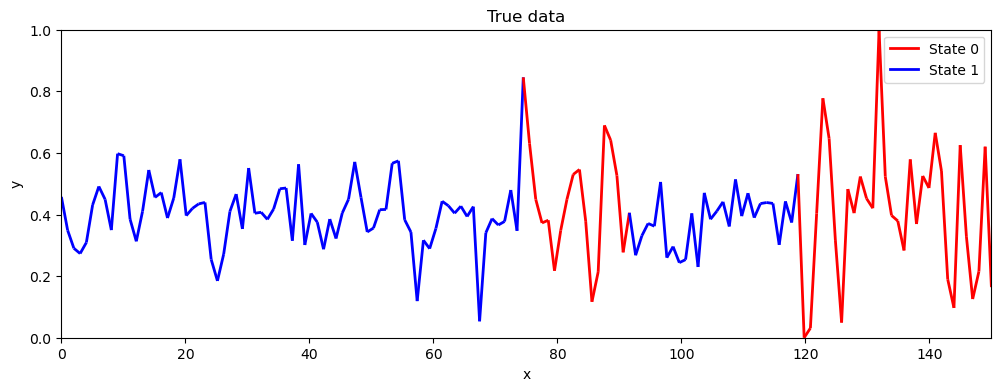

In [12]:
name = 'Toy_dataset_IHMM/'

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from itertools import combinations, permutations
from matplotlib.lines import Line2D


fig = plt.figure(figsize=(12, 4))
# plt.plot(trajectory_generator.traj[:, 0, 0], cmap=plt.cm.jet, color= trajectory_generator.state_sequence.squeeze())
x = np.linspace(0, 150, 150)
y = trajectory_generator.traj[:, 0, 0]

max_y = jnp.max(jnp.abs(y)) 
min_y = jnp.min(y)
y_new = (y - min_y)/(max_y - min_y)

points = np.array([x, y_new]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)
# print(segments.shape)

colors = trajectory_generator.state_sequence.squeeze()
cmap = ListedColormap(['r', 'g', 'b'])
norm = BoundaryNorm([-.5, .5, 1.5, 2.5], cmap.N)
lc = LineCollection(segments, cmap=cmap, norm=norm)
lc.set_array(colors)
lc.set_linewidth(2)
line = plt.gca().add_collection(lc)
# fig.colorbar(line)
z = np.unique(colors)

def make_proxy(zvalue, scalar_mappable, **kwargs):
    color = scalar_mappable.cmap(scalar_mappable.norm(zvalue))
    return Line2D([0, 1], [0, 1], color=color, **kwargs)
proxies = [make_proxy(item, lc, linewidth=2) for item in z]
plt.legend(proxies, ['State 0', 'State 1', 'State 2'], frameon=True)



# plt.figure(figsize=(10, 4))
# plt.plot(x, f_new, 'k', label=r'')
# plt.plot(x, y_new, 'rx', label='obs')
plt.xlabel('x')
plt.ylabel('y')
plt.title('True data')
plt.xlim(x.min(), x.max())
# plt.ylim(y_new.min(), y_new.max())
plt.show()


# print(y_new.shape)
jnp.save(name + 'data.npy', y_new)
jnp.save(name + 'orig_data.npy', y)
# jnp.save(name + 'ground_truth.npy', ground_truth)
base_kernel = jk.RBF()

kernel = Discontinuous_multiple_params_hyper(base_kernel)

max_CP = 10
T = 1 

priors = dict(kernel= dict(lengthscale=LogNormal_mod(0, 2, max_CP+1),
                             variance=LogNormal_mod(0, 2, max_CP+1),
                             num=Poisson_Process_hyper(max_CP, T)),
              likelihood=dict(obs_noise=LogNormal_mod(0, 1, 1)),
              hyper = dict(hyper_1 = LogNormal_mod(0, 1, 1)) 
                       )

num_particles = 1000

GP_marginal = GP_CP_Marginal(x[:, jnp.newaxis], y, cov_fn=kernel, priors=priors, num_particles=num_particles)
jnp.save(name + 'GP_marginal_untrained_orig.npy', GP_marginal)

GP_latent = GP_CP_Latent(x[:, jnp.newaxis], y, cov_fn=kernel, priors=priors, num_particles=num_particles)
jnp.save(name + 'GP_latent_untrained_orig.npy', GP_latent)